In [ ]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import os, sys
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
from tqdm import tqdm, tqdm_notebook
sys.path.append('../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../scripts/')
from loadpaths_glc import loadpaths
import data_loading_utils as dlu
import glc_prediction_utils as gpu
path_dict = loadpaths()

In [ ]:
dict_dfs, dict_dfs_species, dict_val_species = dlu.load_metadata(create_geo=True, add_h3=False,
                                               create_validation_set=True)
# type(dict_dfs['df_test_pa'])

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Created validation set with 8898 entries


## Average within buffer with threshold

In [ ]:
val_or_test = 'test'

dict_dfs, dict_dfs_species, dict_val_species = dlu.load_metadata(create_geo=True, add_h3=False,
                                create_validation_set=True if val_or_test == 'val' else False)
tmp = gpu.predict_using_buffer(dict_dfs=dict_dfs, dict_dfs_species=dict_dfs_species,
                            save_pred=True, method=f'lc-specific', buffer_deg=0.3,
                            eval_mode=val_or_test)
if val_or_test == 'val':
    f1_score = gpu.compute_f1_score_dicts(dict_val_species, tmp)
    print(f'F1 score: {f1_score}')

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
    LandCover  count
0         0.0     25
1         1.0     15
2         2.0     18
3         4.0     22
4         5.0     16
5         8.0     20
6         9.0     16
7        10.0     19
8        11.0     14
9        12.0     17
10       13.0     16
11       14.0     17
12       15.0     11
13       16.0     12
14       17.0     13


 43%|████▎     | 2049/4716 [00:13<00:17, 149.13it/s]

No nearby points for surveyId: 1695841 (LC: 13.0)


100%|██████████| 4716/4716 [00:31<00:00, 151.01it/s]

Predictions done (4715 total). No nearby points: 1.
Saved predictions to: /Users/t.vanderplas/data_offline/data_geolifeclef2024/predictions_glc2024/GLC24_vdplasthijs_predictions-buffer-lc-0.3-lc-specific_2024-04-18_22-53.csv


## Label propagation

In [ ]:
(df_train, df_test), (df_train_species, df_val_species) = dlu.create_full_pa_ds(val_or_test='test')

Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Dropped 135101/5079797 duplicates in df_train_po_species


In [253]:
tmp = gpu.LabelPropagation(dist_neigh_meter=30000,
                           val_or_test='test', method_weights='pca_dist',
                           filter_lc_exact_match=False, zscore_features=False,
                           preload_weights=False, weights_preload_timestamp='20240421-2043',
                           preload_labels=True, labels_preload_timestamp='20240520-1512')

Dropped PO data because takes ages with geometry
Columns dropped: ['taxonRank', 'geoUncertaintyInM', 'date', 'areaInM2', 'publisher', 'month', 'day', 'region', 'dayOfYear', 'country']
Dropped 49637/1483637 duplicates in df_train_pa_species
Nans in elevation data: 35. Manually fixing now.
Nans in elevation data fixed
Nans in elevation data fixed
Creating sparse weight matrix (93703 iterations)


93703it [03:46, 414.00it/s]


Weights & metdata not saved to file


In [218]:
tmp.load_cos_sim()
tmp.mat_cos_label

<93668x93668 sparse matrix of type '<class 'numpy.float64'>'
	with 18180944 stored elements in Compressed Sparse Row format>

In [219]:
def get_feat_diff(i_feat, random_points, mat_feat, mat_sim):
    new_feat_mat = sp.csr_matrix((mat_sim.shape[0], mat_sim.shape[0]))
    for i in random_points:
        nz_inds = mat_sim[i, :].nonzero()[1]
        ind_feat = mat_feat[i, i_feat]
        curr_feat = mat_feat[nz_inds, i_feat]
        new_feat_mat[i, nz_inds] = np.abs(ind_feat - curr_feat)
    return new_feat_mat

mat_feat = tmp.df_features_merged[['Elevation'] + [f'Bio{x}' for x in range(1, 20)]].values
random_points = np.random.choice(a=mat_feat.shape[0], size=5000, replace=False)
mat_sim = tmp.mat_cos_label
n_feat = mat_feat.shape[1]

tmp_new_mat = sp.csr_matrix((mat_sim.shape[0], mat_sim.shape[1]))
for i in tqdm(random_points):
    nz_inds = mat_sim[i, :].nonzero()[1]
    tmp_new_mat[i, nz_inds] = mat_sim[i, nz_inds]
nz_inds_all = tmp_new_mat.nonzero()

data_labels = mat_sim[nz_inds_all].A.flatten()
data_features = np.zeros((len(data_labels), n_feat))
for i_feat in tqdm(range(n_feat)):
    new_feat_mat = get_feat_diff(i_feat, random_points, mat_feat, mat_sim)
    data_features[:, i_feat] = new_feat_mat[nz_inds_all].A.flatten()

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_index.py:136: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
  0%|          | 0/20 [00:00<?, ?it/s]/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
100%|██████████| 20/20 [03:57<00:00, 11.87s/it]


In [220]:
assert data_features.min() >= 0
sim_feat = 1 / (1 + data_features)
import statsmodels.api as sm
X = sm.add_constant(sim_feat)  
model = sm.OLS(data_labels, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1078.
Date:                Sat, 18 May 2024   Prob (F-statistic):               0.00
Time:                        23:45:53   Log-Likelihood:             4.7176e+05
No. Observations:              958586   AIC:                        -9.435e+05
Df Residuals:                  958565   BIC:                        -9.432e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0945      0.004    -23.914      0.000      -0.102      -0.087
x1             0.1479      0.004     33.132      0.000       0.139       0.157
x2            -0.0550      0.007     -8.234      0.000      -0.068      -0.042
x3             0.1246      0.004     28.830      0.000       0.116       0.133
x4            -0.0047      0.001     -4.129      0.000      -0.007      -0.002
x5            -0.0779      0.005    -15.891      0.000      -0.088      -0.068
x6            -0.0735      0.005    -13.925      0.000      -0.084      -0.063
x7            -0.2865      0.007    -39.847      0.000      -0.301      -0.272
x8             0.1547      0.007     22.812      0.000       0.141       0.168
x9             0.0140      0.001     10.480      0.000       0.011       0.017
x10            0.0185      0.002      8.450      0.000       0.014       0.023
x11            0.1008      0.006     18.029      0.000       0.090       0.112
x12            0.0792      0.007     11.222      0.000       0.065       0.093
x13            0.3118      0.011     29.542      0.000       0.291       0.333
x14            0.1548      0.007     23.815      0.000       0.142       0.168
x15            0.0072      0.005      1.377      0.169      -0.003       0.018
x16            0.1484      0.004     37.233      0.000       0.141       0.156
x17           -0.3348      0.010    -34.278      0.000      -0.354      -0.316
x18           -0.0212      0.007     -3.087      0.002      -0.035      -0.008
x19           -0.0263      0.003     -8.260      0.000      -0.033      -0.020
x20           -0.0204      0.004     -4.700      0.000      -0.029      -0.012
==============================================================================
Omnibus:                   107597.199   Durbin-Watson:                   1.595
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147858.490
Skew:                           0.917   Prob(JB):                         0.00
Kurtosis:                       3.585   Cond. No.                         387.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [228]:
import scipy.stats
scipy.stats.rankdata(np.abs(model.tvalues[1:]))

array([17.,  5., 15.,  3., 11., 10., 20., 13.,  8.,  7., 12.,  9., 16.,
       14.,  1., 19., 18.,  2.,  6.,  4.])

0.1700577452615281


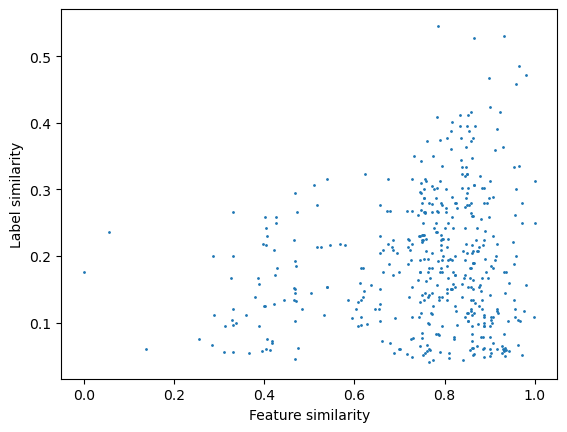

In [ ]:
df_feat = tmp.df_train[['Elevation', 'Bio1', 'Bio2', 'Bio3', 'Bio4', 'Bio5', 'Bio6', 'Bio7', 'Bio8', 'Bio9', 'Bio10', 'Bio11', 'Bio12', 'Bio13', 'Bio14', 'Bio15', 'Bio16', 'Bio17', 'Bio18', 'Bio19']]
# df_feat = tmp.df_train[['LandCover']]
focal_ind = 120
# cos_use = tmp_cos
cos_use = new_cos
nz_inds = cos_use[focal_ind, :].nonzero()[1]
df_feat = df_feat.iloc[nz_inds, :] - df_feat.iloc[focal_ind, :]
dist_arr = df_feat.abs().sum(1).values
sim_arr_feat =  1 - dist_arr / dist_arr.max()
plt.scatter(sim_arr_feat, cos_use[focal_ind, nz_inds].toarray().flatten(), s=1)
plt.xlabel('Feature similarity')
plt.ylabel('Label similarity')
print(np.corrcoef(sim_arr_feat, cos_use[focal_ind, nz_inds].toarray().flatten())[0, 1])

In [254]:
tmp.n_iter = 50
_ = tmp.fit()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_base.py:713: RuntimeWarning: divide by zero encountered in divide
  recip = np.true_divide(1., other)
/Users/t.vanderplas/anaconda3/envs/geoclef/lib/python3.10/site-packages/scipy/sparse/_index.py:136: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
Difference between epochs: 6.3: 100%|██████████| 50/50 [01:21<00:00,  1.62s/it]   

Converged after 50/50 iterations


- data points $i, j$: distance $d_{ij} = \sum_k | f_k(i) - f_k(j) | \cdot \nu_k$ such that $ 0 \leq d_{ij} < \inf$

- similarity then is: $s_{ij} = \frac{1}{\epsilon + d_{ij}}$, such that $ 0 < s_{ij} \leq \epsilon^{-1} $ (should therefore $\epsilon = 1$?)

- for satellite images; $f_k(i) = CNN(x_i | \theta)$ where $\theta$ is partly trained.
- for all others $f_k(i) = g(x_i)$ with no parameters to train. (either unity function, or PCA or something)

- For the species labels $y_i$, we define similarity as the cosine similarity: $s_{ij}^l = \frac{y_i \cdot y_j}{|| y_i || \cdot || y_j || }$ such that $0 \leq s_{ij}^l \leq 1$


Training: 
- Loss: $L(i, j) = MSE(s_{ij}, s_{ij}^l)$ if geographic distance $i, j < \tau$, else 0
- backprop $\{\nu_k, \theta\}$
- training: 1) take sample $i$, 2) find inds neighbours $< \tau$, 3) get matrix of $| f_k(i) - f_k(j) |$ (rows $j$, cols $k$), 4) multiply with $\nu_k$ and col-sum, 5) similarity and MSE loss, 6) backprop.
- CNN not sure ... ? 

100%|██████████| 4716/4716 [00:05<00:00, 829.45it/s]


Predictions done. No species found: 22/4716.
Saved predictions to: /Users/t.vanderplas/data_offline/data_geolifeclef2024/predictions_glc2024/2024-05-20_15-49_GLC24_vdplasthijs_predictions-label-prop-lc-30000m-0.15.csv


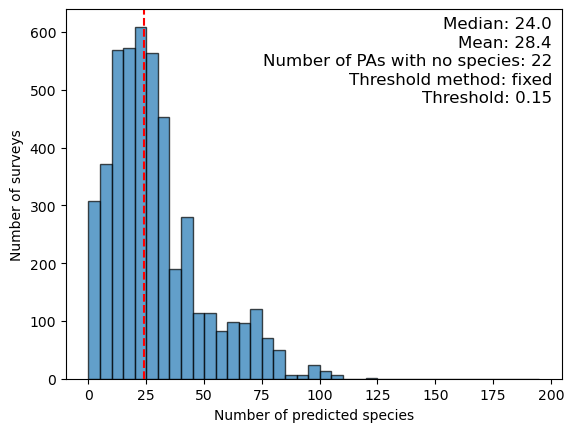

In [256]:
threshold_method = 'fixed'
threshold_weighted_labels = 0.15
save_pred = True

dict_pred, count_no_species = tmp.create_predictions(threshold_method=threshold_method,
                                   threshold_weighted_labels=threshold_weighted_labels, 
                                   save_pred=save_pred)

ax = plt.subplot(111)
ax.hist([len(v) for k, v in dict_pred.items()], bins=np.arange(0, 200, 5),
         edgecolor='black', alpha=0.7);
ax.set_xlabel('Number of predicted species')
ax.set_ylabel('Number of surveys')
ax.axvline(np.median([len(v) for k, v in dict_pred.items()]), color='red', linestyle='dashed')

## print info in top righ tocrner
ax.text(0.98, 0.98, f'Median: {np.median([len(v) for k, v in dict_pred.items()])}',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

ax.text(0.98, 0.93, f'Mean: {np.round(np.mean([len(v) for k, v in dict_pred.items()]), 1)}',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

ax.text(0.98, 0.88, f'Number of PAs with no species: {count_no_species}',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

ax.text(0.98, 0.83, f'Threshold method: {threshold_method}',
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='black', fontsize=12)

if threshold_method == 'fixed':
    ax.text(0.98, 0.78, f'Threshold: {threshold_weighted_labels}',
            verticalalignment='top', horizontalalignment='right',
            transform=ax.transAxes,
            color='black', fontsize=12)

Text(0, 0.5, 'Val')

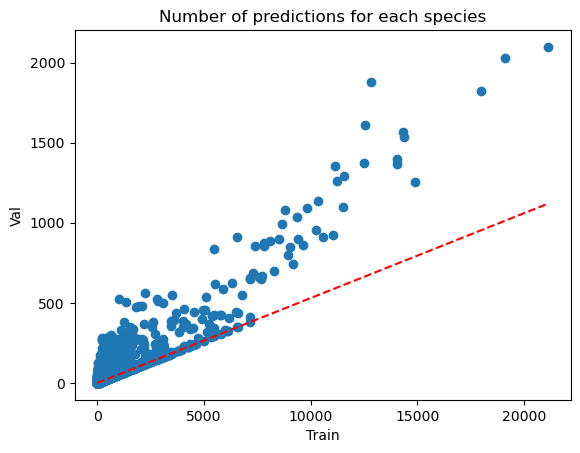

In [252]:
mat_train = sp.csc_matrix(tmp.mat_labels_thresholded[:tmp.n_train, :])
mat_val = sp.csc_matrix(tmp.mat_labels_thresholded[tmp.n_train:, :])

total_train = np.squeeze(np.array(mat_train.sum(axis=0)))
total_val = np.squeeze(np.array(mat_val.sum(axis=0)))
             
expected_slope = len(tmp.df_test) / tmp.n_train
x_exp = [0, np.max(total_train)]
y_exp = [0, expected_slope * np.max(total_train)]
plt.plot(x_exp, y_exp, color='red', linestyle='dashed')

plt.scatter(total_train, total_val)
plt.title('Number of predictions for each species')
plt.xlabel('Train')
plt.ylabel('Val')

# plt.xlim([0, 50])

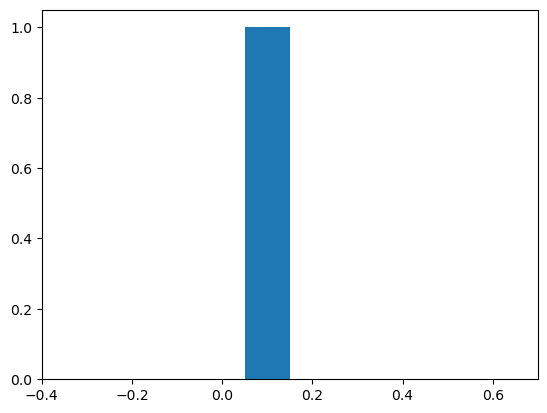

In [248]:
plt.hist(tmp.thresholds_test);

In [ ]:
arr_th = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3]
arr_f1 = []
for th in arr_th:
    dict_pred = tmp.create_predictions(threshold_weighted_labels=th)
    for k in dict_val_species.keys():
        if k not in dict_pred.keys():
            dict_pred[k] = []
    f1 = gpu.compute_f1_score_dicts(dict_val_species, dict_pred)
    arr_f1.append(f1)

In [ ]:
print('F1 scores 20 km:')
for th, f1 in zip(arr_th, arr_f1):
    print(f'Th: {th}, F1: {f1}')

F1 scores 20 km:
Th: 0.01, F1: 0.17815909998542828
Th: 0.03, F1: 0.22171562850602888
Th: 0.05, F1: 0.2550898257417876
Th: 0.07, F1: 0.2813144225923728
Th: 0.1, F1: 0.31055241911795095
Th: 0.15, F1: 0.33787610690510994
Th: 0.2, F1: 0.34126959671664947
Th: 0.3, F1: 0.29877385480062507


In [ ]:
for th, f1 in zip(arr_th, arr_f1):
    print(f'Th: {th}, F1: {f1}')

Th: 0.01, F1: 0.1993253455507175
Th: 0.03, F1: 0.2339567857022029
Th: 0.05, F1: 0.26306820509513906
Th: 0.07, F1: 0.2874202966047946
Th: 0.1, F1: 0.3149615778560888
Th: 0.15, F1: 0.34330129624560624
Th: 0.2, F1: 0.35171820741153903
Th: 0.3, F1: 0.32425812748704147
